In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from time import time

# Neural Networks

## Building Blocks

1. An **input layer** formed of training examples $\mathbf{X}$ consisting of $m$ feature vectors $\mathbf{X}=[\mathbf{x}^{(1)},\mathbf{x}^{(2)},\dots,\mathbf{x}^{(m)}]$, where each $\mathbf{x}^{(i)}$ contains $n$ features $[x_1, x_2, \dots, x_n]^{(i)}$.
2. One or more **hidden layer(s)** formed of hidden units each of which takes a weighted sum of the previous layer's units and subsequently applies a non-linearity function $f$ (e.g. ReLU). The weighted sum of the $l$-th layer is performed by matrix multiplication: $\mathbf{z}^{(l)} = \mathbf{a}^{(l-1)}\cdot\mathbf{W}^{(l)} + \mathbf{b}^{(l)}$. Subsequently, the non-linearity function is applied $\mathbf{a}^{(l)}=f(\mathbf{z}^{(l)})$.
3. An **output layer** consisting of one (binary classification) or $C$ output units where $C$ is the number of classes. Each output unit takes the weighted sum of the previous layer's units. Subsequently a normalizing function (sigmoid for binary classification, softmax for multi-class classification) is applied over the output units to obtain the predicted soft labels.
4. An **objective function** $L$ for learning (e.g. cross-entropy loss).
6. An **optimization algorithm** that optimizes the objective function (e.g. gradient descent).

## Binary Classification

### Forward Propagation

#### Example: Neural Network with One Hidden Layer

We subsequently feed our training examples through the network to obtain label predictions:

$\text{Input: } \mathbf{x}^{(i)}\in \mathbb{R}^{n_\text{features}} \quad$

$
    \mathbf{z}^{(1)} = \cdot\mathbf{W}^{(1)}\mathbf{x}^{(i)} + \mathbf{b}^{(1)}\quad\vert\quad \mathbf{W}^{(1)} \in \mathbb{R}^{n_\text{hidden_layer}\times n_\text{features}} \quad \mathbf{b}^{(1)} \in \mathbb{R}^{n_\text{hidden_layer}}
$

$
\mathbf{a}^{(1)} = \text{ReLU}(\mathbf{z}^{(1)})\quad\vert\quad\mathbf{z}^{(1)},\mathbf{a}^{(1)}\in\mathbb{R}^{ n_\text{hidden_layer}}
$

$
z^{(2)} = \mathbf{a}^{(1)}\cdot\mathbf{w}^{(2)} + b^{(2)} \quad\vert\quad \mathbf{w}^{(2)} \in \mathbb{R}^{n_\text{hidden_layer}} \quad b^{(2)} \in \mathbb{R}
$

$
\hat{y} = \sigma(z^{(2)})\quad\vert\quad z^{(2)},\hat{y}\in\mathbb{R} 
$

In [2]:
MAX_EXP = 709

def sigmoid(z):
    z = np.clip(z, -MAX_EXP, None) # For numerical stability
    return 1 / (1 + np.exp(-z))

In [3]:
def relu(z):
    return z * (z > 0)

In [4]:
def relu_prime(z):
    return 1.0 * (z > 0)

---

### Loss Function

As described in [Logistic Regression](./Logistic_Regression.ipynb), we can use [binary cross-entropy loss](./Logistic_Regression.ipynb#The-Binary-Cross-Entropy-Loss-Function) for binary classification:

$$L_{CE}(\hat{y},y)=-\log{p(y\vert \mathbf{x})} = -\big(y\log{\hat{y}}+(1-y)\log{(1-\hat{y})}\big)$$

In [5]:
EPSILON = 1e-9

def ce_loss(y_hat, y):
    y_hat = np.clip(y_hat, EPSILON, 1 - EPSILON) # For numerical stability
    loss = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss

---

### Backward Propagation: Gradient Descent

In order to perform gradient descent, we need to obtain the following partial derivatives:

$$
\frac{\partial L}{\partial \mathbf{W}^{(1)}}\quad \frac{\partial L}{\partial \mathbf{b}^{(1)}} \quad \frac{\partial L}{\partial \mathbf{w}^{(2)}} \quad \frac{\partial L}{\partial b^{(2)}} \quad 
$$

#### Derivation

Let's derive these by using the chain rule and start with some initial calculations:

$$\frac{\partial L}{\partial \hat{y}} = \frac{1-y}{1-\hat{y}} -\frac{y}{\hat{y}} = \frac{\hat{y}-y}{\hat{y}-\hat{y}^2}$$

$$
\frac{\partial \hat{y}}{\partial z^{(2)}} = \sigma'(z^{(2)})=\sigma(z^{(2)})(1-\sigma(z^{(2)}))=\hat{y}(1-\hat{y})=\hat{y}-\hat{y}^2
$$

Hence, applying the chain rule, we can say that:

$$\delta^{(1)}=\frac{\partial L}{\partial z^{(2)}} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z^{(2)}}= \frac{\hat{y}-y}{\hat{y}-\hat{y}^2}(\hat{y}-\hat{y}^2) = \hat{y}-y\quad\vert\quad\delta^{(1)}\in \mathbb{R}
$$

It follows:

$$\frac{\partial L}{\partial b^{(2)}} = \frac{\partial L}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial b^{(2)}} = \delta^{(1)}$$

$$
\frac{\partial L}{\partial \mathbf{w}^{(2)}}=\frac{\partial L}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial \mathbf{w}^{(2)}}
=\delta^{(1)}\mathbf{a}^{(1)}\quad\vert\quad\delta^{(1)}\mathbf{a}^{(1)}\in \mathbb{R}^{n_\text{hidden_layer}}
$$

Next, we need:

$$
\delta^{(2)} =\frac{\partial L}{\partial \mathbf{z}^{(1)}} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z^{(2)}}\frac{\partial z^{(2)}}{\partial \mathbf{a}^{(1)}}\frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}=\delta^{(1)}\frac{\partial z^{(2)}}{\partial \mathbf{a}^{(1)}}\frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}
$$

$$
\frac{\partial z^{(2)}}{\partial \mathbf{a}^{(1)}}=\mathbf{w}^{(2)} \quad\frac{\partial \mathbf{a}^{(1)}}{\partial \mathbf{z}^{(1)}}=\text{ReLU}'(\mathbf{z}^{(1)})
$$

$$
\delta^{(2)}=\delta^{(1)}\mathbf{w}^{(2)} \circ \text{ReLU}'(\mathbf{z}^{(1)})\quad\vert\quad\delta^{(2)}\in \mathbb{R}^{n_\text{hidden_layer}}
$$

It follows:

$$
\frac{\partial L}{\partial \mathbf{b}^{(1)}} = \frac{\partial L}{\partial \mathbf{z}^{(1)}}\frac{\partial \mathbf{z}^{(1)}}{\partial{\mathbf{b}^{(1)}}}  = \delta^{(2)}\frac{\partial \mathbf{z}^{(1)}}{\partial{\mathbf{b}^{(1)}}}=\delta^{(2)}
$$

$$
\frac{\partial L}{\partial \mathbf{W}^{(1)}} = \frac{\partial L}{\partial \mathbf{z}^{(1)}}\frac{\partial \mathbf{W}^{(1)}}{\partial{\mathbf{b}^{(1)}}}  = \delta^{(2)}\frac{\partial \mathbf{z}^{(1)}}{\partial{\mathbf{W}^{(1)}}}=\delta^{(2)}\cdot\mathbf{x}^{T(i)}\quad\vert\quad\delta^{(2)}\cdot\mathbf{x}^{T(i)}\in \mathbb{R}^{n_\text{hidden_layer}\times n_\text{features}}
$$

---

### Gradient Update

We update our parameters as follows:

$$
\mathbf{W}^{(1)}_{t+1} = \mathbf{W}^{(1)}_t - \eta \frac{\partial L}{\partial \mathbf{W}^{(1)}_t}\quad\vert\quad
\mathbf{b}^{(1)}_{t+1} = \mathbf{b}^{(1)}_t - \eta \frac{\partial L}{\partial \mathbf{b}^{(1)}_t}\quad\vert\quad
\mathbf{w}^{(2)}_{t+1} = \mathbf{w}^{(2)}_t - \eta \frac{\partial L}{\partial \mathbf{w}^{(2)}_t}\quad\vert\quad
b^{(2)}_{t+1} = b^{(2)}_t - \eta \frac{\partial L}{\partial b^{(2)}_t}
$$

where $\eta$ is the learning rate.

---

### Vectorization

In practice, we put the whole (mini-)batches through our neural net at once. The forward and backward passes then look as follows:

#### Forward Propagation

$\mathbf{Z}^{(1)} = \mathbf{X}\cdot \mathbf{W}^{(1)}+\mathbf{b}^{(1)} \quad\vert\quad \mathbf{Z}^{(1)} \in \mathbb{R}^{n_\text{examples}\times n_\text{hidden}}$

$\mathbf{A}^{(1)} = \text{ReLU}(\mathbf{Z}^{(1)}) \quad\vert\quad \mathbf{A}^{(1)} \in \mathbb{R}^{n_\text{examples}\times n_\text{hidden}}$

$\mathbf{z}^{(2)} = \mathbf{A}^{(1)}\cdot \mathbf{w}^{(2)} + b^{(2)} \quad\vert\quad \mathbf{z}^{(2)} \in\mathbb{R}^{n_\text{examples}}$

$\mathbf{\hat{y}} = \sigma(\mathbf{z}^{(2)})\quad\vert\quad \hat{\mathbf{y}} \in\mathbb{R}^{n_\text{examples}}$

#### Backward Propagation

$\delta^{(1)} =\frac{\partial L}{\partial \mathbf{z}^{(2)}}= \mathbf{\hat{y}}-\mathbf{y}\quad\vert\quad \delta^{(1)} \in\mathbb{R}^{n_\text{examples}}$

$\frac{\partial L}{\partial b^{(2)}}= \sum_{k=1}^{n_\text{examples}}\delta^{(1)}_k$

$\frac{\partial L}{\partial \mathbf{w}^{(2)}}= \mathbf{A}^{T(1)}\delta^{(1)}$

$
\delta^{(2)} =\frac{\partial L}{\partial \mathbf{Z}^{(1)}} =\delta^{(1)}\frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{A}^{(1)}}\frac{\partial \mathbf{A}^{(1)}}{\partial \mathbf{Z}^{(1)}}=\delta^{(1)}\cdot\mathbf{w}^{T(2)}\circ\text{ReLU}'(\mathbf{Z}^{(1)})\quad\vert\quad \delta^{(2)} \in\mathbb{R}^{n_\text{examples}\times n_\text{hidden}}
$

$\frac{\partial L}{\partial \mathbf{b}^{(1)}}= \sum_{k=1}^{n_\text{examples}}\delta^{(2)}$

$\frac{\partial L}{\partial \mathbf{W}^{(1)}}= \mathbf{X}^{T}\delta^{(2)}$

---

### Code

In [6]:
def next_batch(X, y, batch_size):
    """
    Creates a training batch generator which itself returns batches.

    Parameters
    ----------
    X : array (2-D)
        the training examples of shape [n_examples, n_features].
    y : array (1-D)
        the ground truth labels associated with the training set of shape [n_examples,].
    batch_size : int
        mini-batch size for training. 

    Yields
    ----------
    X_batch : array (2-D)
        of shape [batch_size, n_features]
    y_batch : array (1-D)
        of shape [batch_size, 1]
    """
    n_examples, _ = X.shape

    # Parallely shuffle the examples
    p = np.random.permutation(n_examples)
    X, y = X[p], y[p]

    for batch_offset in range(0, n_examples, batch_size):
        if n_examples < batch_offset + batch_size:
            return
        X_batch = X[batch_offset:batch_offset + batch_size]
        y_batch = y[batch_offset:batch_offset + batch_size]
        yield X_batch, y_batch

In [7]:
class NeuralNetwork:
    """
    This model is a simple model for binary classification consisting of an input layer, 
    one hidden layer and and output layer.
    """
    
    def __init__(self, hidden_size=100):
        """
        Initialize the neural network model.

        Parameters
        ----------
        hidden_size : int, default: 100
            the number of hidden units.
        """
        self.n_hidden = hidden_size
        
    def forward(self, X):
        """
        Run one forward propagation pass through the network.

        Parameters
        ----------
        X : array (2-D)
            the data to be passed through the network of shape [n_examples, n_features].
            
        Returns
        ----------
        (array, array, array)
            y_hat: array (1-D)
                the predictions of shape [n_examples,].
        """
        # Input -> hidden
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = relu(self.Z1)
        
        # Hidden -> output
        z2 = self.A1.dot(self.w2) + self.b2
        y_hat = sigmoid(z2)
        
        return y_hat
    
    def backward(self, X, y, y_hat):
        """
        Run one backward propagation pass through the network.

        Parameters
        ----------
        X : array (2-D)
            the data that has been passed through the network 
            in the previous forward pass of shape [n_examples, n_features].
        y : array (1-D)
            the ground truth labels of shape [n_examples,].
        y_hat : array (1-D)
            the predictions of shape [n_examples]
            
        Returns
        ----------
        (float, array, array, array)
            grad_b2 : float
                the partial derivative w.r.t b2.
            grad_w2: array (1-D)
                the partial derivative w.r.t. w2 of shape [n_hidden,].
            grad_b1: array (1-D)
                the partial derivative w.r.t. b1 of shape [n_hidden,].
            grad_W1: array (2-D)
                the partial derivative w.r.t. W1 of shape [n_features, n_hidden].
        """
        delta1 = y_hat - y
        grad_b2 = delta1.sum()
        grad_w2 = self.A1.T.dot(delta1)
        
        delta2 = np.outer(delta1, self.w2.T) * relu_prime(self.Z1)
        grad_b1 = delta2.sum(axis=0)
        grad_W1 = X.T.dot(delta2)
        
        return grad_b2, grad_w2, grad_b1, grad_W1
    
    def train(self, X, y, batch_size=16, learning_rate=0.001, n_epochs=1000, print_every=100):
        """
        Run neural network training on the given training set.

        Parameters
        ----------
        X : array (2-D)
            the training examples of shape [n_examples, n_features].
        y : array (1-D)
            the ground truth labels associated with the training set of shape [n_examples,].
        batch_size : int, default: 32
            mini-batch size for training.
        learning_rate : float, default: 0.001
            the learning rate.
        n_epochs : int, default: 1000
            the number of epochs used for training.
        print_every : int, default: 100
            indicates how often the current loss is printed.
        """
        n_examples, n_features = X.shape
        
        # 1. Initialize Parameters
        self.W1 = np.random.randn(n_features, self.n_hidden)
        self.b1 = np.random.randn(self.n_hidden)
        
        self.w2 = np.random.randn(self.n_hidden)
        self.b2 = np.random.randn()
        
        self.losses = []
        
        start = time()
        for i in range(n_epochs):

            running_loss = []
            n_batches = 0

            # 2. Generate and shuffle mini-batches
            for X_batch, y_batch in next_batch(X, y, batch_size):

                # 3. Compute y_hat for the mini-batch
                y_hat = self.forward(X_batch)

                # 4. Compute loss
                loss = (1 / batch_size) * np.sum(ce_loss(y_hat, y_batch))
                running_loss.append(loss)

                # 5. Compute the gradients
                grads = self.backward(X_batch, y_batch, y_hat)
                grad_b2, grad_w2, grad_b1, grad_W1 = grads

                # 6. Update parameters
                self.b2 -= learning_rate * grad_b2
                self.w2 -= learning_rate * grad_w2
                self.b1 -= learning_rate * grad_b1
                self.W1 -= learning_rate * grad_W1

                n_batches += 1

            epoch_loss = sum(running_loss) / n_batches
            self.losses.append(epoch_loss)
            if i == 0 or (i + 1) % print_every == 0:
                print(f"Epoch: {i + 1}/{n_epochs}\t Loss: {epoch_loss}")
        
        elapsed = time() - start
        print(f"Done 🥳. Training took {elapsed} seconds.")
            
    def test(self, X, y, threshold=0.5):
        """
        Test trained model on the given test set.

        Parameters
        ----------
        X : array (2-D)
            the test examples of shape [n_examples, n_features].
        y : array (1-D)
            the ground truth labels associated with the test set of shape [n_examples,].
        threshold : float, default: 0.5
            the decision threshold, all values larger than this value will be assigned to class 1.
            
        Returns
        ----------
        (float, float)
            accuracy : float
                how accurately the test set was predicted
            f1 : float
                the F1 score, i.e. the harmonic mean of precision and recall
        """
        threshold = min(1, max(0, threshold))
        y_hat = self.forward(X)
        y_hat[y_hat > threshold] = 1
        y_hat[y_hat <= threshold] = 0
        diff = y_hat - y
        n = len(y)
        tp = len(diff[diff == 0])
        fp = len(diff[diff == 1])
        fn = len(diff[diff == -1])
        accuracy = tp / n
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        return accuracy, f1

### Dataset

We run training on an SMS dataset in order to classify wheter a given SMS is spam or ham. The dataset can be obtained [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

#### Load Dataset

In [8]:
sms_df = pd.read_csv(os.path.join("data", "SMSSpamCollection"), sep="\t", header=None, names=["class", "message"])

In [9]:
sms_df.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


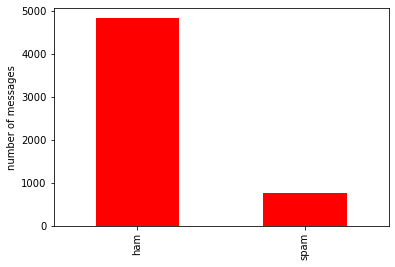

In [10]:
_ = sms_df["class"].value_counts().plot(kind="bar", color="r", ylabel="number of messages")

We can see that the data is rather unbalanced at this moment. Thus, we drop *ham* messages to balance out the distribution.

In [11]:
n_ham_messages = sms_df[sms_df["class"] == "ham"].count()[0]
n_spam_messages = sms_df[sms_df["class"] == "spam"].count()[0]
n_difference = n_ham_messages - n_spam_messages

In [12]:
drop_messages = sms_df[sms_df["class"] == "ham"].sample(n_difference).index

In [13]:
sms_df.drop(drop_messages, inplace=True)

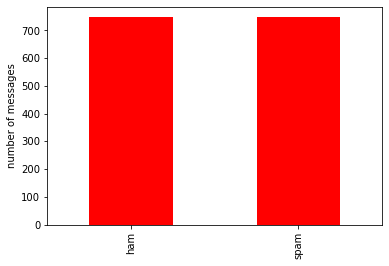

In [14]:
_ = sms_df["class"].value_counts().plot(kind="bar", color="red", ylabel="number of messages")

In [15]:
n_ham_messages = sms_df[sms_df["class"] == "ham"].count()[0]
n_spam_messages = sms_df[sms_df["class"] == "spam"].count()[0]

In [16]:
print(f"There are {n_ham_messages} ham and {n_spam_messages} spam messages in the dataset.")

There are 747 ham and 747 spam messages in the dataset.


As we can see, we now have an equal count of ham and spam messages.

#### Vectorize the data

We will use the character counts within our SMS messages as input feature.

In [17]:
count_vectorizer = CountVectorizer(analyzer="char")

In [18]:
X = count_vectorizer.fit_transform(sms_df["message"])
y = pd.get_dummies(sms_df["class"], drop_first=True).to_numpy().reshape(-1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

### Run Training

Let us now try to classify ham vs. spam using our small neural network.

In [20]:
nn = NeuralNetwork()
nn.train(X_train, y_train)

Epoch: 1/1000	 Loss: 3.573318857974244
Epoch: 100/1000	 Loss: 0.00281407741354602
Epoch: 200/1000	 Loss: 0.0011412850557561951
Epoch: 300/1000	 Loss: 0.0007413974494171933
Epoch: 400/1000	 Loss: 0.0005393859602731699
Epoch: 500/1000	 Loss: 0.0004337870843533006
Epoch: 600/1000	 Loss: 0.00035629135512806634
Epoch: 700/1000	 Loss: 0.0003044060347697841
Epoch: 800/1000	 Loss: 0.0002650675823143821
Epoch: 900/1000	 Loss: 0.00023407767013235238
Epoch: 1000/1000	 Loss: 0.0002100983292426165
Done 🥳. Training took 27.588141679763794 seconds.


### Test the Model

In [21]:
accuracy_train, f1_train = nn.test(X_train, y_train)
print(f"The accuracy_train on the training set is {accuracy_train * 100} %")
print(f"The f1_train score on the training set is {f1_train * 100} %")

The accuracy_train on the training set is 100.0 %
The f1_train score on the training set is 100.0 %


In [22]:
accuracy_test, f1_test = nn.test(X_test, y_test)
print(f"The accuracy on the test set is {accuracy_test * 100} %")
print(f"The F1 score on the test set is {f1_test * 100} %")

The accuracy on the test set is 93.31550802139037 %
The F1 score on the test set is 96.54218533886585 %


#### Qualitatively Test Some Random Messages

In [23]:
spam_message = ["Hello, I am Prince from Nigeria. I have $1.000.000 for you. Give me your bank account for transfer"]
ham_message = ["Yo, whatsup? Haven't heard of you in a long time! Wanna meet up tonight at 8.00? :)"]

In [24]:
spam_X = count_vectorizer.transform(spam_message)
ham_X = count_vectorizer.transform(ham_message)

In [25]:
print(spam_message[0], "\n---> Spam with a probability of {0:.3g} %".format(nn.forward(spam_X)[0] * 100))
print()
print(ham_message[0], "\n---> Spam with a probability of {0:.3g} %".format(nn.forward(ham_X)[0] * 100))

Hello, I am Prince from Nigeria. I have $1.000.000 for you. Give me your bank account for transfer 
---> Spam with a probability of 100 %

Yo, whatsup? Haven't heard of you in a long time! Wanna meet up tonight at 8.00? :) 
---> Spam with a probability of 4.36e-07 %


---

## Multi-class Classification

As described in the [Logistic Regression notebook](./Logistic_Regression.ipynb) our ground truth labels consist of more than just two classes. Instead of the sigmoid function, in the output layer we use the [softmax function](./Logistic_Regression.ipynb#The-Softmax-Function) to obtain soft labels over all classes and [categorical cross-entropy](./Logistic_Regression.ipynb#The-Categorical-Cross-Entropy-Loss-Function) as loss function.

In [26]:
MAX_EXP = 709

def softmax(z):
    z -= np.max(z)
    z = np.clip(z, -MAX_EXP, None) # For numerical stability
    exp = np.exp(z)
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [27]:
EPSILON = 1e-9

def categorical_ce_loss(Y_hat, Y):
    Y_hat = np.clip(Y_hat, EPSILON, 1 - EPSILON) # For numerical stability
    return - np.sum(Y * np.log(Y_hat))

Forward and backward propragation are almost identical with the binary counterpart, apart from the fact that the sigmoid activation function on the output layer is replaced with softmax.

#### Forward Propagation

$\mathbf{Z}^{(1)} = \mathbf{X}\cdot \mathbf{W}^{(1)}+\mathbf{b}^{(1)} \quad\vert\quad \mathbf{Z}^{(1)} \in \mathbb{R}^{n_\text{examples}\times n_\text{hidden}}$

$\mathbf{A}^{(1)} = \text{ReLU}(\mathbf{Z}^{(1)}) \quad\vert\quad \mathbf{A}^{(1)} \in \mathbb{R}^{n_\text{examples}\times n_\text{hidden}}$

$\mathbf{Z}^{(2)} = \mathbf{A}^{(1)}\cdot \mathbf{W}^{(2)} + \mathbf{b}^{(2)} \quad\vert\quad \mathbf{Z}^{(2)} \in\mathbb{R}^{n_\text{examples}\times n_\text{classes}}$

$\mathbf{\hat{Y}} = \text{softmax}(\mathbf{Z}^{(2)})\quad\vert\quad \hat{\mathbf{Y}} \in\mathbb{R}^{n_\text{examples}\times n_\text{classes}}$

#### Backward Propagation

$\delta^{(1)} =\frac{\partial L}{\partial \mathbf{Z}^{(2)}}= \mathbf{\hat{Y}}-\mathbf{Y}\quad\vert\quad \delta^{(1)} \in\mathbb{R}^{n_\text{examples}\times n_\text{classes}}$

$\frac{\partial L}{\partial \mathbf{b}^{(2)}}= \sum_{k=1}^{n_\text{examples}}\delta^{(1)}_k$

$\frac{\partial L}{\partial \mathbf{W}^{(2)}}= \mathbf{A}^{T(1)}\delta^{(1)}$

$
\delta^{(2)} =\frac{\partial L}{\partial \mathbf{Z}^{(1)}} =\delta^{(1)}\frac{\partial \mathbf{Z}^{(2)}}{\partial \mathbf{A}^{(1)}}\frac{\partial \mathbf{A}^{(1)}}{\partial \mathbf{Z}^{(1)}}=\delta^{(1)}\cdot\mathbf{W}^{T(2)}\circ\text{ReLU}'(\mathbf{Z}^{(1)})\quad\vert\quad \delta^{(2)} \in\mathbb{R}^{n_\text{examples}\times n_\text{hidden}}
$

$\frac{\partial L}{\partial \mathbf{b}^{(1)}}= \sum_{k=1}^{n_\text{examples}}\delta^{(2)}$

$\frac{\partial L}{\partial \mathbf{W}^{(1)}}= \mathbf{X}^{T}\delta^{(2)}$

### Code

In [28]:
class MultiClassNeuralNetwork:
    """
    This model is a simple model for multiclass classification consisting of an input layer, 
    one hidden layer and and output layer.
    """
    
    def __init__(self, hidden_size=500):
        """
        Initialize the neural network model.

        Parameters
        ----------
        hidden_size : int, default: 500
            the number of hidden units.
        """
        self.n_hidden = hidden_size
        
    def forward(self, X):
        """
        Run one forward propagation pass through the network.

        Parameters
        ----------
        X : array (2-D)
            the data to be passed through the network of shape [n_examples, n_features].
            
        Returns
        ----------
        (array, array, array)
            Y_hat: array (2-D)
                the predictions of shape [n_examples, n_classes].
        """
        # Input -> hidden
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = relu(self.Z1)
        
        # Hidden -> output
        Z2 = self.A1.dot(self.W2) + self.b2
        Y_hat = softmax(Z2)
        
        return Y_hat
    
    def backward(self, X, Y, Y_hat):
        """
        Run one backward propagation pass through the network.

        Parameters
        ----------
        X : array (2-D)
            the data that has been passed through the network 
            in the previous forward pass of shape [n_examples, n_features].
        Y : array (2-D)
            the ground truth labels of shape [n_examples, n_classes].
        Y_hat : array (2-D)
            the predictions of shape [n_examples, n_classes]
            
        Returns
        ----------
        (float, array, array, array)
            grad_b2 : array (1-D)
                the partial derivative w.r.t b2.
            grad_W2: array (2-D)
                the partial derivative w.r.t. w2 of shape [n_hidden, n_classes].
            grad_b1: array (1-D)
                the partial derivative w.r.t. b1 of shape [n_hidden,].
            grad_W1: array (2-D)
                the partial derivative w.r.t. W1 of shape [n_features, n_hidden].
        """
        delta1 = Y_hat - Y
        grad_b2 = delta1.sum(axis=0)
        grad_W2 = self.A1.T.dot(delta1)
        
        delta2 = delta1.dot(self.W2.T) * relu_prime(self.Z1)
        grad_b1 = delta2.sum(axis=0)
        grad_W1 = X.T.dot(delta2)
        
        return grad_b2, grad_W2, grad_b1, grad_W1
    
    def train(self, X, Y, batch_size=64, learning_rate=0.001, n_epochs=1000, print_every=10):
        """
        Run neural network training on the given training set.

        Parameters
        ----------
        X : array (2-D)
            the training examples of shape [n_examples, n_features].
        Y : array (2-D)
            the ground truth labels associated with the training set of shape [n_examples, n_classes].
        batch_size : int, default: 64
            mini-batch size for training.
        learning_rate : float, default: 0.001
            the learning rate.
        n_epochs : int, default: 1000
            the number of epochs used for training.
        print_every : int, default: 10
            indicates how often the current loss is printed.
        """
        n_examples, n_features = X.shape
        _, n_classes = Y.shape
        
        # 1. Initialize Parameters
        self.W1 = np.random.randn(n_features, self.n_hidden)
        self.b1 = np.random.randn(self.n_hidden)
        
        self.W2 = np.random.randn(self.n_hidden, n_classes)
        self.b2 = np.random.randn(n_classes)
        
        self.losses = []
        
        start = time()
        for i in range(n_epochs):

            running_loss = []
            n_batches = 0

            # 2. Generate and shuffle mini-batches
            for X_batch, Y_batch in next_batch(X, Y, batch_size):

                # 3. Compute Y_hat for the mini-batch
                Y_hat = self.forward(X_batch)

                # 4. Compute loss
                loss = (1 / batch_size) * np.sum(categorical_ce_loss(Y_hat, Y_batch))
                running_loss.append(loss)

                # 5. Compute the gradients
                grads = self.backward(X_batch, Y_batch, Y_hat)
                grad_b2, grad_W2, grad_b1, grad_W1 = grads

                # 6. Update parameters
                self.b2 -= learning_rate * grad_b2
                self.W2 -= learning_rate * grad_W2
                self.b1 -= learning_rate * grad_b1
                self.W1 -= learning_rate * grad_W1

                n_batches += 1

            epoch_loss = sum(running_loss) / n_batches
            self.losses.append(epoch_loss)
            if i == 0 or (i + 1) % print_every == 0:
                print(f"Epoch: {i + 1}/{n_epochs}\t Loss: {epoch_loss}")
        
        elapsed = time() - start
        print(f"Done 🥳. Training took {elapsed} seconds.")
            
    def test(self, X, Y):
        """
        Test trained model on the given test set.

        Parameters
        ----------
        X : array (2-D)
            the test examples of shape [n_examples, n_features].
        Y : array (1-D)
            the ground truth labels associated with the test set of shape [n_examples,].
        threshold : float, default: 0.5
            the decision threshold, all values larger than this value will be assigned to class 1.
            
        Returns
        ----------
        accuracy : float
            how accurately the test set was predicted
        """
        Y_hat = self.forward(X)
        predictions = np.argmax(Y_hat, axis=1)
        diff = predictions - Y.argmax(axis=1)
        n = len(diff)
        tp = len(diff[diff == 0])
        return tp / n

### Dataset

#### Load and Preprocess Dataset

In this example, we use the Twitter US Airline Sentiment Dataset. Here, tweets are labeled with one of three sentiment scores (positive, negative or neutral). The dataset can be downloaded [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). We only take items with a confidence of 1.

In [29]:
airlines_df = pd.read_csv(os.path.join("data", "AirlineTweets.csv"), sep=",")
airlines_df = airlines_df[airlines_df["airline_sentiment_confidence"] == 1][["text", "airline", "airline_sentiment"]]

In [30]:
airlines_df.head()

,text,airline,airline_sentiment
0,@VirginAmerica What @dhepburn said.,Virgin America,neutral
3,@VirginAmerica it's really aggressive to blast...,Virgin America,negative
4,@VirginAmerica and it's a really big bad thing...,Virgin America,negative
5,@VirginAmerica seriously would pay $30 a fligh...,Virgin America,negative
9,"@VirginAmerica it was amazing, and arrived an ...",Virgin America,positive


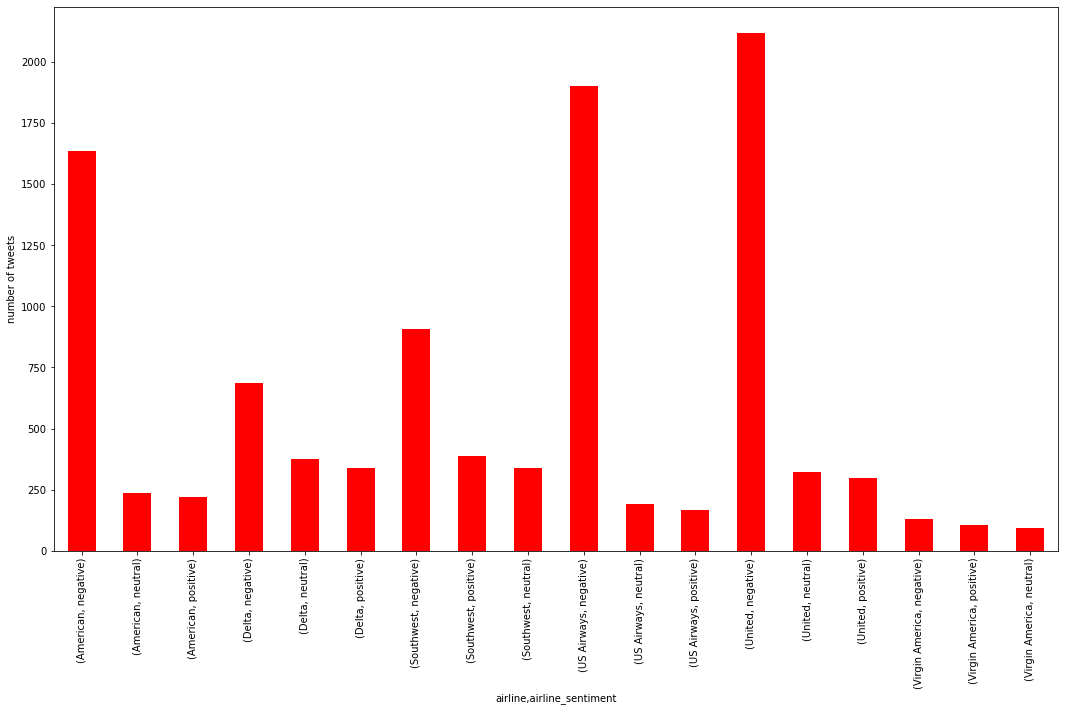

In [31]:
airline_groups = airlines_df.groupby("airline")["airline_sentiment"]
_ = airline_groups.value_counts().plot(kind="bar", color="red", figsize=(18,10), ylabel="number of tweets")

We can see, that the data is very unequally distributed again. In order to avoid bias toward a certain sentiment class, airline (the airline twitter handles are part of the tweet) or the interaction between the two, we randomly sample the data to be of equal size in each of the categories plotted above.

In [32]:
clean_airlines_df = pd.DataFrame(columns=["airline_sentiment","airline","text"])
min_count = airline_groups.value_counts().min()

In [33]:
clean_airlines_df = airlines_df.groupby(["airline", "airline_sentiment"]).sample(min_count)

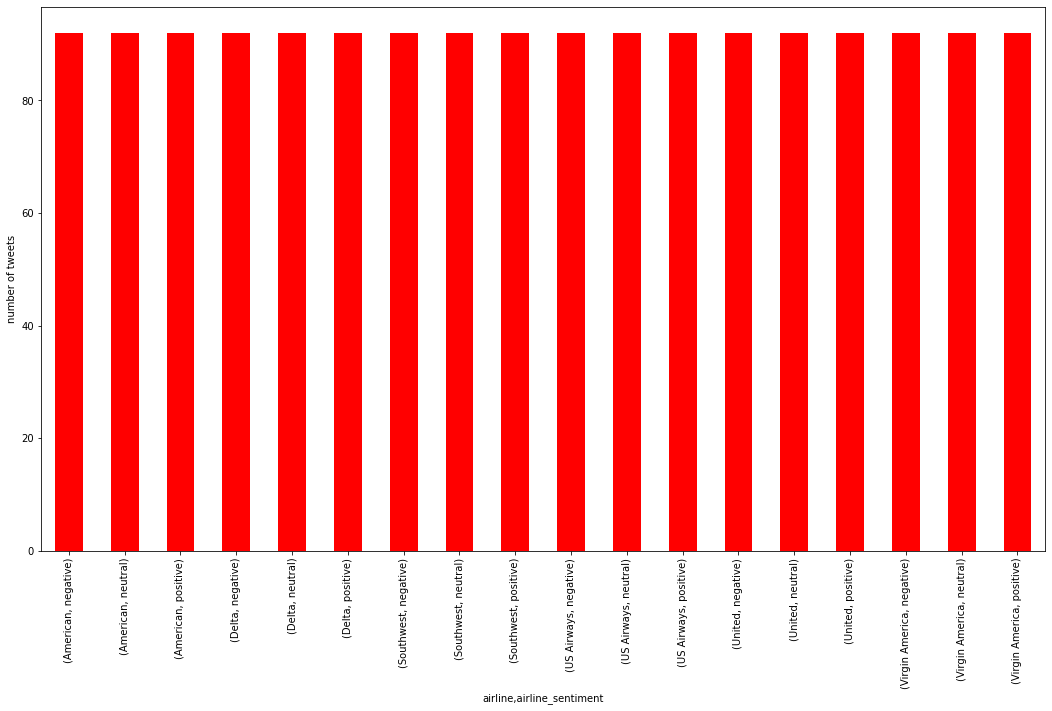

In [34]:
_ = clean_airlines_df.groupby("airline")["airline_sentiment"].value_counts().plot(kind="bar", color="red", figsize=(18,10), ylabel="number of tweets")

As desired, now all category interaction pairs are now balanced out.

#### Vectorize Data

In [35]:
count_vectorizer = CountVectorizer(analyzer="char")

In [36]:
X = count_vectorizer.fit_transform(clean_airlines_df["text"])
Y = pd.get_dummies(clean_airlines_df["airline_sentiment"]).to_numpy()

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True)

In [38]:
print("Data Shapes:", X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Data Shapes: (1242, 126) (1242, 3) (414, 126) (414, 3)


### Run Training

In [39]:
multi_nn = MultiClassNeuralNetwork(hidden_size=50)

In [40]:
multi_nn.train(X_train, Y_train, n_epochs=2000, print_every=200)

Epoch: 1/2000	 Loss: 4.424354944017567
Epoch: 200/2000	 Loss: 0.8322250229029656
Epoch: 400/2000	 Loss: 0.6779444912079343
Epoch: 600/2000	 Loss: 0.5891936427974245
Epoch: 800/2000	 Loss: 0.5233816832276198
Epoch: 1000/2000	 Loss: 0.48252541678758587
Epoch: 1200/2000	 Loss: 0.45139723987570485
Epoch: 1400/2000	 Loss: 0.44775907419721084
Epoch: 1600/2000	 Loss: 0.41956675318307013
Epoch: 1800/2000	 Loss: 0.41842781382314587
Epoch: 2000/2000	 Loss: 0.40669725489145403
Done 🥳. Training took 19.823203086853027 seconds.


### Test the Model

In [41]:
accuracy_train = multi_nn.test(X_train, Y_train)
print(f"The accuracy on the training set is {accuracy_train * 100} %")

The accuracy on the training set is 82.93075684380032 %


In [42]:
accuracy_test = multi_nn.test(X_test, Y_test)
print(f"The accuracy on the test set is {accuracy_test * 100} %")

The accuracy on the test set is 59.17874396135265 %


This task is apparently too hard for our small dataset and very simple features (just character counts) as well as the simple fully-connected architecture. For example, pre-trained word embeddings might yield better performance here. Still, on the test set, we are almost twice as good as guessing which would be a chance of 33.3 %.